# Forwards data analysis

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings("ignore")

**Uploading forwards csv**

In [3]:
forwards_path = '../Datos/forwards_2022-06-29.csv'
df_forwards = pd.read_csv(forwards_path)

In [4]:
# df_forwards.head()

In [5]:
df_forwards.shape[0]
# this is the number of successful forwards your node has recorded

19561

In [6]:
# changing the type of the channel ids to be displayed correctly
df_forwards[['outgoing_channel_id', 'incoming_channel_id']] = df_forwards[['outgoing_channel_id', 
                                                                           'incoming_channel_id']].astype(np.int64)

## Incoming/Outgoing/Balanced tagging task

**Creating df for this task**

In [7]:
task1_df = pd.DataFrame(index=df_forwards['outgoing_channel_id'].value_counts().index, 
                        columns=['times_incoming', 
                                 'times_outgoing', 
                                 'total_incoming_amt',
                                 'total_outgoing_amt'])
task1_df.shape

(185, 4)

In [8]:
# task1_df.head()

In [9]:
# group by incoming/outgoing chhanels
group_incoming = df_forwards.groupby('incoming_channel_id')['incoming_amount_msat']
group_outgoing = df_forwards.groupby('outgoing_channel_id')['outgoing_amount_msat']

In [10]:
# Fill task1_df 
task1_df['times_incoming'] = df_forwards['incoming_channel_id'].value_counts()
task1_df['times_outgoing'] = df_forwards['outgoing_channel_id'].value_counts()
task1_df['total_incoming_amt'] = group_incoming.aggregate('sum')
task1_df['total_outgoing_amt'] = group_outgoing.aggregate('sum')

In [11]:
# task1_df.head(3)

In [12]:
# Searching for nan values
task1_df.isnull().values.any()

True

In [13]:
# replace nan values for 0s
task1_df.fillna(0, inplace=True)

In [14]:
# Searching for nan values
task1_df.isnull().values.any()

False

## Balanced metric
The **Balanced metric** shows whether a channel is balanced. Here, we say a channel is balanced when the forwarding activity is going both ways. It is calculated by:<br>
<center><i>balanced_rate = min(inbound, outbound) / max(inbound, outbound)</i></center>

In [15]:
# Total amount routed
total = task1_df['total_incoming_amt'] + task1_df['total_outgoing_amt']
# Compute balance rate of the channels
balanced_metric = np.minimum(task1_df['total_incoming_amt'], task1_df['total_outgoing_amt']) / np.maximum(task1_df['total_incoming_amt'], task1_df['total_outgoing_amt'])
balanced_metric.describe()

count    185.000000
mean       0.593908
std        0.354774
min        0.000000
25%        0.284634
50%        0.710571
75%        0.905679
max        0.998764
dtype: float64

In [16]:
# balanced_metric.head(2)

The `balanced_metric` is in a scale between 0-1. <br><br>
Now let's plot the following: *(inbound/total_amount_routed) vs (outbound/total_amount_routed)*

This will show a line where in the middle the balanced channels will be placed.

In [17]:
# This is just for style to the charts
import seaborn as sns

sns.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks
plt.rc('axes', titlesize=16)     # fontsize of the axes title
plt.rc('axes', labelsize=13)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize
plt.rc('font', size=12)          # controls default text sizes

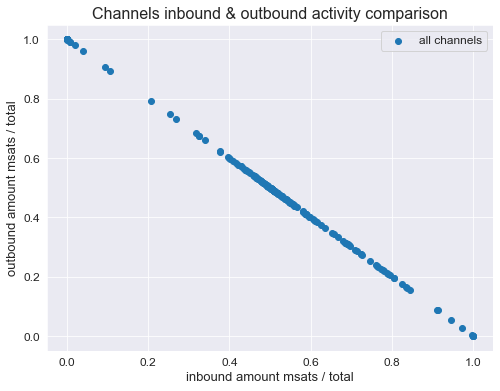

In [18]:
plt.figure(figsize=(8, 6))
x = task1_df['total_incoming_amt']/total
y = task1_df['total_outgoing_amt']/total
plt.scatter(x, y, label='all channels')
plt.xlabel('inbound amount msats / total')
plt.ylabel('outbound amount msats / total')
plt.legend()
_ = plt.title('Channels inbound & outbound activity comparison')

We clearly observe a big cluster in the middle, which represents the balanced channels based on their forwarding activity. We can make sure of this if we plot the points with a balanced rate close to 1.

In [19]:
# Top 60 channels with best balanced rate
top60 = balanced_metric.sort_values(ascending=False)[:60]
t60_x = task1_df.loc[top60.index, 'total_incoming_amt']
t60_y = task1_df.loc[top60.index, 'total_outgoing_amt']

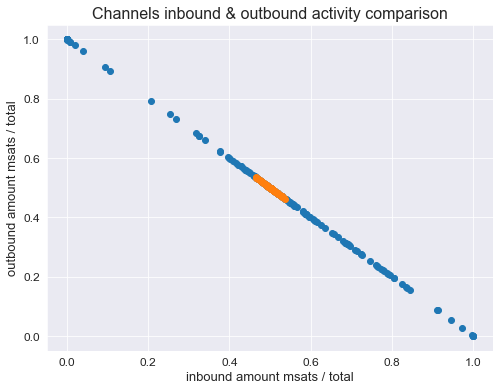

In [20]:
plt.figure(figsize=(8,6))
x = task1_df['total_incoming_amt']/total
y = task1_df['total_outgoing_amt']/total
plt.scatter(x, y)
plt.scatter(t60_x/total, t60_y/total)
plt.xlabel('inbound amount msats / total')
plt.ylabel('outbound amount msats / total')
_ = plt.title('Channels inbound & outbound activity comparison')

We can confirm that this balanced channels analysis is correct

## Balanced rate vs normalized volume

We've already stablished a balanced metric to show which channels are balanced. If we plot it against a normalized version of the total volume, i.e. inbound + outbound, we'll see which channels are both balanced and highly active.

In [21]:
# normalizing total volume
total_volume = total.values
norm = total_volume/np.linalg.norm(total_volume)
norm_volume = pd.Series(norm, index=total.index)

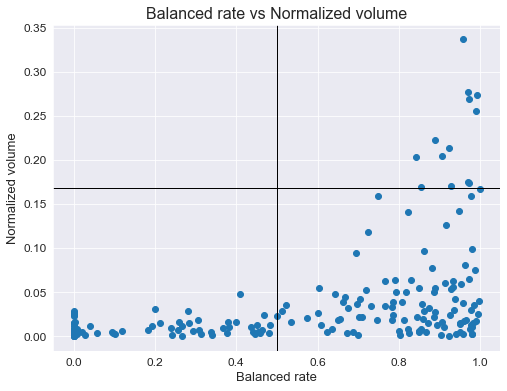

In [22]:
plt.figure(figsize=(8,6))

plt.scatter(balanced_metric, norm_volume)
plt.xlabel('Balanced rate')
plt.ylabel('Normalized volume')

x_avg = (balanced_metric.min() + balanced_metric.max()) / 2
y_avg = (norm_volume.min() + norm_volume.max())/2
plt.axvline(x_avg, c='black', lw=1)
plt.axhline(y_avg, c='black', lw=1)
_ = plt.title('Balanced rate vs Normalized volume')

We observe a 4 tile grid, where in Q1 are located the most balanced and highly active channels

We can see who these channels are:

In [23]:
balanced_metric.name, norm_volume.name = "balanced_rate", "normalized_volume"
channels_comparison = pd.merge(balanced_metric, norm_volume, left_index=True, right_index=True)
# query for channels in Q1
mask = (channels_comparison['balanced_rate'] > 0.5) & (channels_comparison['normalized_volume'] > y_avg)

In [24]:
# Uncomment the cell below to see the channels that are the most balanced and highly active

In [25]:
# channels_comparison[mask]

## Balanced rate vs normalized revenue

We can do a similar this as above but with a normalized version of the total revenue earned per channels instead of the volume. This will show what channels are both balanced and generate value overall.

In [26]:
# total revenue
total_revenue_df = df_forwards.groupby('outgoing_channel_id')['fee_msat'].aggregate('sum')
# normalizing revenue
total_revenue = total_revenue_df.values
norm = total_revenue/np.linalg.norm(total_revenue)
norm_revenue = pd.Series(norm, index=total.index)

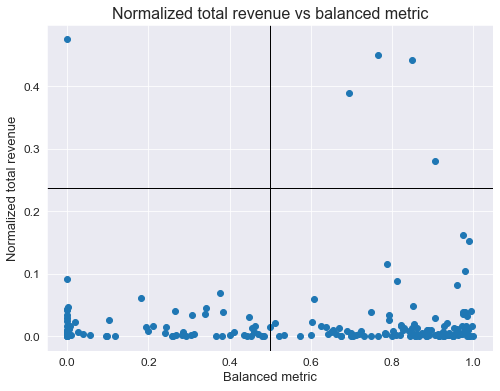

In [27]:
plt.figure(figsize=(8,6))
plt.scatter(balanced_metric, norm_revenue)

plt.xlabel('Balanced metric')
plt.ylabel('Normalized total revenue')
# 4 tile grid
x_avg = (balanced_metric.min() + balanced_metric.max()) / 2
y_avg = (norm_revenue.min() + norm_revenue.max())/2
plt.axvline(x_avg, c='black', lw=1)
plt.axhline(y_avg, c='black', lw=1)
_ = plt.title('Normalized total revenue vs balanced metric')

We also observe a 4 tile grid where in Q1 are the channels that are the most balanced and generate the most value.

We can see who these channels are:

In [28]:
norm_revenue.name = "normalized_revenue"
channels_comparison = pd.merge(channels_comparison, norm_revenue, left_index=True, right_index=True)
# query for channels in Q1
mask = (channels_comparison['balanced_rate'] > 0.5) & (channels_comparison['normalized_revenue'] > y_avg)

In [29]:
# Uncomment the cell below to see the channels that are the most balanced and generate the most value

In [30]:
# channels_comparison[mask]

# HTLC data analysis

**Uploading htlc dataset**

In [31]:
htlc_path = '../Datos/htlc_2022-06-29.csv'
df_htlc = pd.read_csv(htlc_path)

In [32]:
# df_htlc.head()

In [33]:
df_htlc[['outgoing_channel_id', 'incoming_channel_id']] = df_htlc[['outgoing_channel_id', 
                                                                   'incoming_channel_id']].astype(np.int64)

In [34]:
df_htlc['event_origin'].unique()
# Forward events are labeld as 'FORWARD' & '3'

array(['FORWARD', 'RECEIVE', 'SEND', '3', '2', '1', 3, 2, 1], dtype=object)

In [35]:
# Filtering df to have only forward events
mask = ((df_htlc['event_origin'] == 'FORWARD') | (df_htlc['event_origin'] == '3'))

In [36]:
df_htlc[mask]['event_origin'].unique()

array(['FORWARD', '3'], dtype=object)

In [37]:
# Apply filter
htlc_forwards = df_htlc[mask]
print(f'{htlc_forwards.shape[0]} htlcs')

1052356 htlcs


In [38]:
# fails
ForwardFailEvents = htlc_forwards[htlc_forwards['event_type'] == 'ForwardFailEvent']
df_failures = ForwardFailEvents.copy()

In [39]:
print(f'This node has recorded {ForwardFailEvents.shape[0]} htlcs failures')

This node has recorded 497639 htlcs failures


## Success rate

This measures how successful a channel is, in a scale from 0-1, where a 1 means the channel has successfully forwarded all payments

In [40]:
# failures
failures = df_failures.groupby('outgoing_channel_id').size()
# forward attempts
mask = htlc_forwards['event_type'] == 'ForwardEvent'
fwd_att = htlc_forwards[mask].groupby('outgoing_channel_id').size()

In [41]:
success_rate = (1-(failures/fwd_att))

In [42]:
# success_rate.sort_values()

## See failure rate of the nodes our channels are linked to

In [43]:
channels_path = '../Datos/channel_events_2022-06-29.csv'
df_channels = pd.read_csv(channels_path)
df_channels['chan_id'] = df_channels['chan_id'].astype(np.int64)

In [44]:
# df_channels.head(3)

In [45]:
# Node events dataset (node alias)
nodes_path = '../Datos/node_events_2022-06-29.csv'
df_nodes = pd.read_csv(nodes_path)

In [46]:
# df_nodes.head(3)

In [47]:
# fails
ForwardFailEvents = htlc_forwards[htlc_forwards['event_type'] == 'ForwardFailEvent']

In [48]:
# ForwardFailEvents.head(3)

In [49]:
# total
total_fws = htlc_forwards.copy()
total_fws.time = pd.to_datetime(total_fws.time)
total_df = total_fws.set_index('time')

In [50]:
ForwardFailEvents.time = pd.to_datetime(ForwardFailEvents.time)

In [51]:
FFE_df = ForwardFailEvents.set_index('time')

In [52]:
def add_pubkey(fails, channels):
    channels = channels.drop_duplicates(['chan_id'], keep='last')
    channels['chan_id'] = channels['chan_id'].astype(np.int64)
    fails['pubkey'] = ''
    out_chan_ids = fails['outgoing_channel_id'].unique()
    
    for i in out_chan_ids:
        
        for z, j in channels[['chan_id', 'pub_key']].iterrows():
            
            if i == j['chan_id']:
                fails.loc[fails['outgoing_channel_id'] == i, 'pubkey'] = j['pub_key']
                
                break
                
    return fails['pubkey']

In [53]:
total_df['pubkey'] = add_pubkey(total_df, df_channels)

In [54]:
total_df.shape

(1052356, 15)

In [55]:
FFE_df['pubkey'] = add_pubkey(FFE_df, df_channels)

In [56]:
# ForwardFailEvents.head(3)

In [57]:
# FFE_df.head(3)

In [58]:
failures = FFE_df.groupby('pubkey').size()

In [59]:
failures.head(2)

pubkey
0203f3e0fdaa52ca5c804d145b6a47e5a620c02123106578230061deb212e720bd    3097
0205306aa071fc026a4884c210d99d886f199068a6ccc65ec1bde085f846be3641    4098
dtype: int64

In [60]:
total = total_df[total_df['event_type'] == 'ForwardEvent'].groupby('pubkey').size()

In [61]:
total.head(2)

pubkey
0203f3e0fdaa52ca5c804d145b6a47e5a620c02123106578230061deb212e720bd    3104
0205306aa071fc026a4884c210d99d886f199068a6ccc65ec1bde085f846be3641    4113
dtype: int64

In [62]:
success_rate_failures = (1-(failures/total))
success_rate = success_rate_failures.copy()
success_rate.sort_values(ascending=False).iloc[:5]

pubkey
037659a0ac8eb3b8d0a720114efc861d3a940382dcfa1403746b4f8f6b2e8810ba    0.698182
0253064653c3c2b52ea76201a24771580ac562902fb603b7b077c347a2420d7190    0.694900
021c97a90a411ff2b10dc2a8e32de2f29d2fa49d41bfbb52bd416e460db0747d0d    0.423077
030ed0e8c35b473e0cdf3b384262688be36a2a7bb61ecf34c836df5b29c81dcd79    0.374199
022ba42f1a9a7b5ee9f3a783b02ce401c06930414fd1386c714a9987d51f3b475a    0.266667
dtype: float64

In [63]:
success_rate.reset_index()['pubkey'].nunique()

118

This are some nodes of interest in our special case

In [64]:
interesting_nodes = ['c-otto.de', 'SWISS.SOVEREIGN', 
                     'zero fee routing | CLN', 'WalletOfSatoshi.com', 
                     'bfx-lnd0', 'bfx-lnd1', 'okex', 
                    'BCash_Is_Trash']
pub_keys=['027ce055380348d7812d2ae7745701c9f93e70c1adeb2657f053f91df4f2843c71',
          '03d4e028a0d4a90868ec202ab684fb0085779defea9ca7553e06146557631eec20',
          '038fe1bd966b5cb0545963490c631eaa1924e2c4c0ea4e7dcb5d4582a1e7f2f1a5',
          '035e4ff418fc8b5554c5d9eea66396c227bd429a3251c8cbc711002ba215bfc226',
          '033d8656219478701227199cbd6f670335c8d408a92ae88b962c49d4dc0e83e025',
          '03cde60a6323f7122d5178255766e38114b4722ede08f7c9e0c5df9b912cc201d6',
          '0294ac3e099def03c12a37e30fe5364b1223fd60069869142ef96580c8439c2e0a',
          '0298f6074a454a1f5345cb2a7c6f9fce206cd0bf675d177cdbf0ca7508dd28852f']

## SEE ALL NODES BEHAVIOUR IN OUR GRAPH

See the metrics obtained so far for the nodes our channels are linked to

In [65]:
def add_node_alias(rate_df, nodes):

    rate_df = rate_df.reset_index()
    rate_df['node_alias'] = ''
#     print(rate_df)
    nodes_pubkeys = rate_df['pubkey'].unique()
    
    for i in nodes_pubkeys:
        
        for ix, j in nodes[['pub_key', 'alias']].iterrows():
            
            if i == j['pub_key']:
                rate_df.loc[rate_df['pubkey'] == i, 'node_alias'] = j['alias']
                
                break
    rate_df = rate_df.set_index('pubkey')
    
    return rate_df['node_alias']
    

In [66]:
success_rate.head(2)

pubkey
0203f3e0fdaa52ca5c804d145b6a47e5a620c02123106578230061deb212e720bd    0.002255
0205306aa071fc026a4884c210d99d886f199068a6ccc65ec1bde085f846be3641    0.003647
dtype: float64

In [67]:
s_r_df = success_rate.copy()
s_r_df = s_r_df.reset_index()
s_r_df['alias'] = ''
s_r_df.set_index('pubkey', inplace=True)

In [68]:
s_r_df.head(2)

,0,alias
pubkey,,
0203f3e0fdaa52ca5c804d145b6a47e5a620c02123106578230061deb212e720bd,0.002255,
0205306aa071fc026a4884c210d99d886f199068a6ccc65ec1bde085f846be3641,0.003647,


In [69]:
# Adding node alias 
s_r_df['alias'] = add_node_alias(success_rate, df_nodes)

In [70]:
s_r_df.rename({0:'success_rate'}, axis=1, inplace=True)

In [71]:
s_r_df.sort_values(by='success_rate', ascending=False).head(3)

,success_rate,alias
pubkey,,
037659a0ac8eb3b8d0a720114efc861d3a940382dcfa1403746b4f8f6b2e8810ba,0.698182,ln.nicehash.com [Nicehash]
0253064653c3c2b52ea76201a24771580ac562902fb603b7b077c347a2420d7190,0.694900,noserver4u
021c97a90a411ff2b10dc2a8e32de2f29d2fa49d41bfbb52bd416e460db0747d0d,0.423077,LOOP


**Adding balanced metric**

In [72]:
def add_pubkey2(series, channels):
    channels = channels.drop_duplicates(['chan_id'], keep='last')
    channels['chan_id'] = channels['chan_id'].astype(np.int64)
    series = series.reset_index().rename({'index':'outgoing_channel_id',
                                      0:'balanced_metric'}, axis=1)
    series['pubkey'] = ''
    out_chan_ids = series['outgoing_channel_id'].unique()
    
    for i in out_chan_ids:
        
        for z, j in channels[['chan_id', 'pub_key']].iterrows():
            
            if i == j['chan_id']:
                series.loc[series['outgoing_channel_id'] == i, 'pubkey'] = j['pub_key']
                
                break
#     print(series.index)     
    return series['pubkey']

In [73]:
b_m_df = balanced_metric.copy()
b_m_df = b_m_df.reset_index()
b_m_df['pubkey'] = add_pubkey2(balanced_metric, df_channels)

b_m_df.set_index('pubkey', inplace=True)

In [74]:
# droping duplicates
# duplicates occur because sometimes you close a channel and open another one with the same peer.
b_m_df = b_m_df.reset_index().sort_values(by='balanced_rate').drop_duplicates('pubkey', keep='last')

In [75]:
b_m_df.set_index('pubkey', inplace=True)

**Join balanced metric and success rate in the same df**

In [76]:
comparing_node_df = pd.merge(s_r_df, b_m_df['balanced_rate'], left_index=True, right_index=True)

In [77]:
comparing_node_df.sort_values(by='success_rate', ascending=False)

,success_rate,alias,balanced_rate
pubkey,,,
037659a0ac8eb3b8d0a720114efc861d3a940382dcfa1403746b4f8f6b2e8810ba,0.698182,ln.nicehash.com [Nicehash],0.730948
0253064653c3c2b52ea76201a24771580ac562902fb603b7b077c347a2420d7190,0.694900,noserver4u,0.998764
021c97a90a411ff2b10dc2a8e32de2f29d2fa49d41bfbb52bd416e460db0747d0d,0.423077,LOOP,0.000000
030ed0e8c35b473e0cdf3b384262688be36a2a7bb61ecf34c836df5b29c81dcd79,0.374199,FriendsWithBenefits,0.959066
022ba42f1a9a7b5ee9f3a783b02ce401c06930414fd1386c714a9987d51f3b475a,0.266667,Routing24/7Bitcoin,0.000000
...,...,...,...
026db2cbf3d8ab4a4c01eed2df432d20cf0a13136402097574209d2595cb9e9d93,0.000000,⚡️ bCyber ⚡️,0.000000
02fc63f7b07cc69c756d432f77ce36ce4e5dbe24f43f3638f38f726d7ac1d9ecc4,0.000000,JDs.Connection,0.981045
0296b46141cd8baf13f3eff9bb217c5f62ce0a871886559d661af0ef422c042d4b,0.000000,EDON,0.874059


In [78]:
best_success_rate_nodes = success_rate.sort_values(ascending=False).iloc[:30]

In [79]:
comparing_node_df['total_Forwards'] = total_df.groupby('pubkey')['event_type'].value_counts()[:,'ForwardEvent']

In [80]:
# comparing_node_df.head(3)

In [81]:
# Seeing the behaviour of the nodes of interest
comparing_node_df.loc[pub_keys,:].sort_values(by='total_Forwards', ascending=False)

,success_rate,alias,balanced_rate,total_Forwards
pubkey,,,,
0298f6074a454a1f5345cb2a7c6f9fce206cd0bf675d177cdbf0ca7508dd28852f,0.009389,BCash_Is_Trash,0.889287,32486.0
027ce055380348d7812d2ae7745701c9f93e70c1adeb2657f053f91df4f2843c71,0.026347,c-otto.de,0.983971,29225.0
038fe1bd966b5cb0545963490c631eaa1924e2c4c0ea4e7dcb5d4582a1e7f2f1a5,0.035517,zero fee routing | c-lightning,0.992703,20863.0
033d8656219478701227199cbd6f670335c8d408a92ae88b962c49d4dc0e83e025,0.015461,bfx-lnd0,0.484106,3040.0
03d4e028a0d4a90868ec202ab684fb0085779defea9ca7553e06146557631eec20,0.032591,SWISS.SOVEREIGN,0.927653,1258.0
0294ac3e099def03c12a37e30fe5364b1223fd60069869142ef96580c8439c2e0a,0.084677,okex,0.791212,744.0
035e4ff418fc8b5554c5d9eea66396c227bd429a3251c8cbc711002ba215bfc226,0.225564,WalletOfSatoshi.com,0.792625,133.0
03cde60a6323f7122d5178255766e38114b4722ede08f7c9e0c5df9b912cc201d6,0.166667,bfx-lnd1,0.040178,90.0


We see that as the total number of forwards sent from a channel to that node increases, the success_rate decreases. This is only for the nodes of interest here.

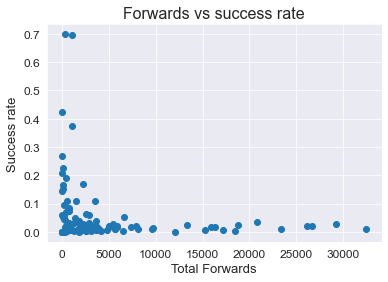

In [82]:
# We can see if the above idea generalizes with a scatter plot comparing those features
plt.scatter(comparing_node_df['total_Forwards'], comparing_node_df['success_rate'])
plt.xlabel('Total Forwards')
plt.ylabel('Success rate')
_ = plt.title('Forwards vs success rate')

We are only interested in routing nodes. So we might filter some data

In [83]:
the_filter = comparing_node_df.describe().loc['25%', 'total_Forwards']
# filter out channels whose total_forwards feature is less than the 25th quantile
# and whose success_rate is considered as outlier (this can be subjective now)
outlier_scc_rate = 0.35 # You can change this value based on the chart above.

In [84]:
active_routing_nodes = comparing_node_df[(comparing_node_df['total_Forwards'] > the_filter) & (comparing_node_df['success_rate'] < outlier_scc_rate)]

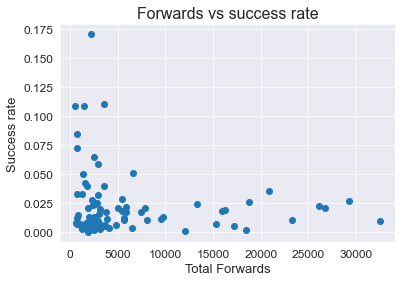

In [85]:
# active_routing_nodes = comparing_node_df[comparing_node_df['total_Forwards'] > the_filter]

plt.scatter(active_routing_nodes['total_Forwards'], active_routing_nodes['success_rate'])
plt.xlabel('Total Forwards')
plt.ylabel('Success rate')
_ = plt.title('Forwards vs success rate')

We observe that the channels with bigger success rate are also the ones with not that much total forwards. This might suggest that in order to increase the success rate of a channel, increasing the forward attempts of the channel has not a big weight on it.

In [86]:
import seaborn as sns

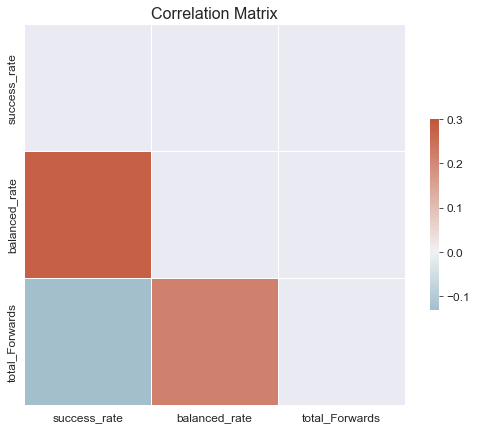

In [87]:
# Compute the correlation matrix
corr = active_routing_nodes[['success_rate','balanced_rate','total_Forwards']].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(9, 7))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

_ = plt.title('Correlation Matrix')

In [88]:
corr

,success_rate,balanced_rate,total_Forwards
success_rate,1.000000,0.276779,-0.131584
balanced_rate,0.276779,1.000000,0.213419
total_Forwards,-0.131584,0.213419,1.000000


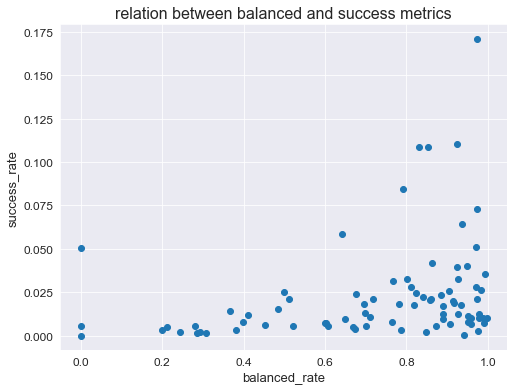

In [96]:
plt.figure(figsize=(8,6))
plt.scatter(active_routing_nodes['balanced_rate'], active_routing_nodes['success_rate'])
plt.xlabel('balanced_rate')
plt.ylabel('success_rate')
_ = plt.title('relation between balanced and success metrics')

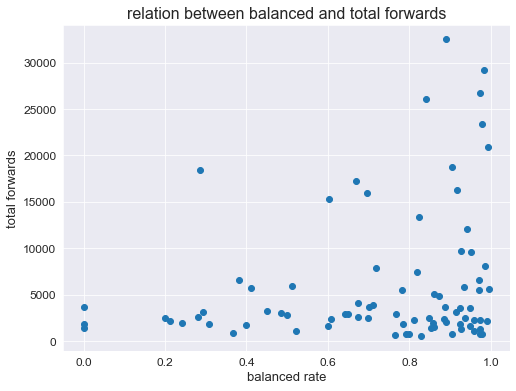

In [95]:
plt.figure(figsize=(8,6))
plt.scatter(active_routing_nodes['balanced_rate'], active_routing_nodes['total_Forwards'])
plt.xlabel('balanced rate')
plt.ylabel('total forwards')
_ = plt.title('relation between balanced and total forwards')

- We can see there's a positive correlation between the balanced rate and the success rate. When a channel is balanced, then  there's a chance it's success rate is better than other channels. It makes sense, since when you have a channel that, due to its outbound & inbound forwarding behaviour it balances naturally, then it can keep sending and receiving forwards, without them failing due to that channel.
- We observe the total forwards and success rate have a weak negative correlation. Once again, we can say this might suggest that in order to increase the success rate of a channel, increasing the forward attempts of the channel has not a big weight on it.
- We see in the correlation matrix a positive correlation between the balaced rate of a channel an its total forward attempts. The LND path-finding algorithm takes into account the degree to which former payment attempts have been successful. Then, if a channel has a good success rate, by the *relation between balanced and success metrics* described above, it might have a good balanced rate as well. If it performs well, then the forwards sent through that channel might increase, as the path-finding algorithm will take it into account more times.

In [92]:
# Uncomment the cell below to save the active routing nodes df for future analysis

In [93]:
# active_routing_nodes.to_csv('active_routing_nodes.csv', encoding='utf-8')